## Computer generation of fruit shapes from DNA sequence: Cucurbit shapes

### Citation:
M. Pérez-Enciso, C. Pons, A. Graell, A.J. Monforte, L.M. Zingaretti. Computer generation of fruit shapes from DNA sequence. Biorxiv. submitted

In [1]:
# check library version numbers 
import numpy as np
print('numpy: %s' % np.__version__) 
import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: %s' % matplotlib.__version__)
import random
import seaborn as sns
import skimage
import scipy
import plotly
import PIL
from PIL import Image, ImageDraw, ImageFilter
import cv2
print('opencv: %s' % cv2.__version__)
print('PIL: %s' % PIL.__version__)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

numpy: 1.22.4
matplotlib: 3.4.3
opencv: 4.5.1
PIL: 8.3.2


In [2]:
# DL modules
# tensorflow
import tensorflow as tf
print('tensorflow: %s' % tf.__version__)
# keras
from tensorflow import keras
print('keras: %s' % keras.__version__)
from tensorflow.keras import layers
import kerastuner as kt
print('kerastuner: %s' % kt.__version__)
from tensorflow.python.keras import backend as K

tensorflow: 2.4.1
keras: 2.4.0
kerastuner: 1.0.2


## generate genetic data

In [3]:
# function to generate dna
# this function returns an n_ind x (n_qtl+n_snp) array with causative and random snps
def do_sequence(g, n_qtl, s2e=0.1, n_snp=0, permute=False):
    """ 
    Generates simple snp data
    g: n_ind x n_trait matrix with genotype values for each indiv and trait
    n_qtl: array with qtl for each trait
    n_snp: num non causal snps
    """
    dna = []
    n_ind, n_trait = g.shape
    
    for t in range(n_trait):
        for _ in range(n_qtl[t]):
            a = g[:,t] + np.random.normal(0, s2e, n_ind)
            dna.append(a)
            
    # add neutral snps
    for _ in range(n_snp):
        a = np.random.normal(0, s2e, n_ind)
        dna.append(a)

    dna = np.array(dna)
    
    # shuffle snp order (if permute=True)
    if permute: 
       rng = np.random.default_rng()
       rng.shuffle(dna)
    
    # transpose 
    dna = dna.transpose()
    
    # normalize
    scaler = StandardScaler()
    scaler.fit(dna)
    dna = scaler.transform(dna)
    
    return dna

In [4]:
# decoder network dna --> image: generates images out of snp data
def dna2image(n_snp,image_size):
    input = tf.keras.layers.Input(shape=(n_snp))

    x = tf.keras.layers.Dense(np.prod(image_size))(input)
    x = tf.keras.layers.Reshape(image_size+(1,))(x)
    x = tf.keras.layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(8, (3,3), activation='relu', padding='same')(x)
 
    output = tf.keras.layers.Conv2DTranspose(1, (5,5), activation='relu', padding='same')(x)

    return tf.keras.Model(input, output)

In [5]:
# function to plot a sample (n=5) of observed vs predicted fruits
def plot_obs_exp(dna, imgs, model, n=5):
    ilist = np.random.randint(0,dna.shape[0], n)
    image_size = imgs.shape[1:3]
    plt.figure(figsize=(15, 15))
    for i,ind in enumerate(ilist):
        ax = plt.subplot(5, 5, 1+i)
        plt.imshow(imgs[ind,])
        plt.title('Observed:'+str(ind))
        plt.axis("off")
    for i,id in enumerate(ilist):
        ax = plt.subplot(5, 5, 6+i)
        g = tf.expand_dims(dna[id,:], 0)
        img = model.predict(g).reshape(image_size)
        plt.imshow(img)
        plt.title('Predicted:'+str(id))
        plt.axis("off")

## Cucurbit shapes
Transform fruit contours

<class 'PIL.PngImagePlugin.PngImageFile'>


(182, 277)

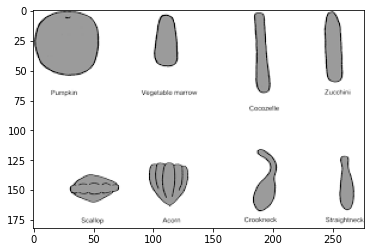

In [9]:
img_bw = PIL.Image.open('images/contours.png')
plt.imshow(img_bw)
print(type(img_bw))
np.asarray(img_bw).shape

In [ ]:
# test other segmentation algorithms
# This is based in https://github.com/lauzingaretti/DeepAFS
img_bw = np.asarray(img_bw)
x = int(np.mean(img_bw))
_, threshold = cv2.threshold(img_bw,x,255,cv2.THRESH_BINARY)
#kernel = np.ones((3,3),np.uint8)
mask = cv2.dilate(cv2.Canny(threshold,0,255),None,iterations=1)    
plt.imshow(mask)

# 
contours, _  = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
len(contours)

: 

In [ ]:
# extract and label contours of interest and their centroids
ids = [3, 4, 5, 11, 12, 13, 14]
contours_used = list(np.array(contours,dtype=object)[ids]) # trick to subset indices from a list
centroids=[]
names = ['Scallop', 'Acorn', 'Straightneck', 'Marrow', 'Zucchini', 'Cocozelle', 'Pumpkin']
imw = np.zeros(img_bw.shape) # blank image
for (i,c) in enumerate(contours_used):
    # compute centroid
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroids.append([cX,cY])
    # draw contour
    cv2.drawContours(imw, c, -1, (255,255,255), 1)
    #cv2.fillPoly(imw, [c], (0,255,0))    
    cv2.putText(imw, str(i), (cX-3, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    plt.imshow(imw)
plt.show()
print('names:',names)
print('centroids:',centroids)
print('n elements:',[c.shape[0] for c in contours_used])

: 

In [ ]:
# Draw all contours to center
imw = np.zeros(img_bw.shape) # blank image
center = np.flip(np.array(imw.shape)//2)
for (i,c) in enumerate(contours_used):
    c = c - centroids[i] + center  # center contour
    cv2.drawContours(imw, c, -1, (255,255,255), 1)
    plt.imshow(imw)
plt.show()
contours_used[0].shape

: 

In [ ]:
# Obtain N pseudolandmarks, take equal rays starting from centroid and moving in circle
# function from LM Zingaretti: https://github.com/lauzingaretti/DeepAFS/
def get_landmarks(img, centroid, N):
    points=[]
    height, width = img.shape
    ref = np.zeros_like(img)
    for i in range(N):
        tmp = np.zeros_like(img)
        theta = i*(360/N)
        theta *= np.pi/180.0
        # Step #6c
        cv2.line(tmp, (centroid[0], centroid[1]),
                 (int(centroid[0]+np.cos(theta)*width),
                 int(centroid[1]-np.sin(theta)*height)), (255, 255, 255), 3)
        try:
            x = int(np.mean(np.nonzero(np.logical_and(tmp, img))[1]))
            y = int(np.mean(np.nonzero(np.logical_and(tmp, img))[0]))
            ref = cv2.circle(ref, (x,y), radius=2, color=(255,255,255), thickness=-1)
            points.append((x,y))
        except:
            continue

    return np.array(points)

: 

In [ ]:
# Obtain N pseudolandmarks
N_ldm = 500
center = np.flip(np.array(img_bw.shape)//2) # image center
landmarks = []
for i in range(7):
    imw = np.zeros(img_bw.shape) # blank image
    c = contours_used[i] - centroids[i] + center  # center contour
    cv2.drawContours(imw, c, -1, (255,255,255), 1)
    landmarks.append(get_landmarks(imw, center, N_ldm))
landmarks = np.array(landmarks)

: 

In [ ]:
# GPA from procrustes library https://github.com/theochem/procrustes
# see also # https://medium.com/@olga_kravchenko/generalized-procrustes-analysis-with-python-numpy-c571e8e8a421
from procrustes import generalized as GPA

landmarks_aligned, new_distance_gpa = GPA(landmarks)
landmarks_aligned = list(np.array(landmarks_aligned, dtype=int))

print('GPA distance: %s ' % new_distance_gpa)

: 

In [ ]:
# show aligned shapes and extract bounding rectangles
imw = np.ones_like(img_bw) # blank image
lmkr_boxes = []
for (i,c) in enumerate(landmarks_aligned):
    c = np.expand_dims(c, axis=1)
    cv2.drawContours(imw, c, -1, (0,255,0), 1)
    lmkr_boxes.append(cv2.boundingRect(c))
    plt.imshow(imw)
plt.show()

# Box enclosing all shapes
lmkr_boxes = np.array(lmkr_boxes)
max_box = (min(lmkr_boxes[:,0]), min(lmkr_boxes[:,1]), max(lmkr_boxes[:,2]), max(lmkr_boxes[:,3]))
x,y,w,h = max_box
#cv2.rectangle(imw, (x,y),(x+w,y+h),(0,255,0))
#plt.imshow(imw)

: 

In [ ]:
# crop and resize image 
imw_cropped = imw[y:y+h, x:x+w]
plt.imshow(imw_cropped)
plt.show()

# choose a bounding square 80 x 80
y = y - (80-h)//2
x = x - (80-w)//2
h, w = 80, 80
max_square = (x,y,w,h)
imw_cropped = imw[y:y+h, x:x+w]
plt.imshow(imw_cropped)
plt.show()

imw_resized = cv2.resize(imw_cropped, (64,64), cv2.IMREAD_UNCHANGED)
plt.imshow(imw_resized)


: 

In [ ]:
# Draw a shape c in center, optionally solid
def draw_shape(img, c, fill=False):
    col = (0,255,0) # black line by default
    if np.mean(img) < 125 : col = (255,255,255) # invert if img=np.zeros
    # expand dims to 3 if needed
    if len(c.shape) == 2: c = np.expand_dims(c, axis=1)
    cv2.drawContours(img, c, -1, col, 1)
    if fill: cv2.fillPoly(img, [c], col)
imw = np.zeros(img_bw.shape)*255
draw_shape(imw,landmarks_aligned[6],True)
plt.imshow(imw)

: 

In [ ]:
# Now let us transform one shape into another, ideally following a known development / evolutive path
def transform_shape(c1, c2, coeff=0.5):
    ''' function to return an intermediate shape with some stochasticity
        - c1, c2: two shapes with aligned landmarks
        - coeff: coefficient of similarity c2-c1
    '''
    c = c1 + (c2-c1)*coeff
    return np.array(c, dtype=int)

# autocorrelated process to induce noise in shape
# https://stackoverflow.com/questions/33898665/python-generate-array-of-specific-autocorrelation
def sample_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"
    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))
    return np.array(signal)

def modify_shape(c1, epsilon=0.01):
    ''' add noise (rugosity) to shapes, ensure autocorrelation between signs
    c1: contour or array
    epsilon: noise
    '''
    c = np.copy(c1)
    if len(c.shape) == 2 : c=np.expand_dims(c, axis=1)
    N = len(c[:,:,0])
    s1 = c[:,:,0].std() * epsilon
    s2 = c[:,:,1].std() * epsilon
    noise_x = sample_signal(N, .9)
    noise_x = noise_x/noise_x.std() * s1
    noise_y = sample_signal(N, .9)
    noise_y = noise_y/noise_y.std() * s2
    c[:,:,0] += np.array(noise_x, dtype=int).reshape(N,1)
    c[:,:,1] += np.array(noise_y, dtype=int).reshape(N,1)
    return np.array(c, dtype=int)

# bend shape starting from centroid so tip is turned right or left deg degrees
def bend_shape(c, deg=0):
    return c

: 

In [ ]:
# add noise to image and smooth contour
epsilon = 0.1
sigma = 1 # this depends on how noisy your data is, play with it!

fig = plt.figure(figsize=(30,10))
i = 0
for la in landmarks_aligned:
    i+=1
    imw = np.zeros_like(img_bw)
    cc = modify_shape(la,epsilon=epsilon)
    draw_shape(imw, cc, fill=True)
    imw = scipy.ndimage.filters.gaussian_filter(imw, sigma)
    fig.add_subplot(2,4,i)
    plt.imshow(imw)

: 

In [ ]:
print(names)

: 

In [ ]:
# intermediate shapes acorn --> scallop
col = (0,255,0)
y = [center[0]-50, center[0]+50]
x = [center[1]-50, center[1]+40]

fig = plt.figure(figsize=(20,20))

imw = np.ones(img_bw.shape) # blank image
c1 = np.expand_dims(landmarks_aligned[6], axis=1)
c2 = np.expand_dims(landmarks_aligned[3], axis=1)
c3 = transform_shape(c1,c2)
cv2.drawContours(imw, c1, -1, col, 1)
cv2.drawContours(imw, c2, -1, col, 1)
cv2.drawContours(imw, c3, -1, col, 1)
imw = imw[x[0]:x[1], y[0]:y[1]]
cv2.putText(imw, 'Pumpkin -> Marrow', (0, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, col, 1)
fig.add_subplot(141)
plt.imshow(imw)

imw = np.ones(img_bw.shape) # blank image
c2 = np.expand_dims(landmarks_aligned[0], axis=1)
c3 = transform_shape(c1,c2)
cv2.drawContours(imw, c1, -1, col, 1)
cv2.drawContours(imw, c2, -1, col, 1)
cv2.drawContours(imw, c3, -1, col, 1)
imw = imw[x[0]:x[1], y[0]:y[1]]
cv2.putText(imw, 'Pumpkin -> Scallop', (0, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, col, 1)
fig.add_subplot(142)
plt.imshow(imw)

imw = np.ones(img_bw.shape) # blank image
c2 = np.expand_dims(landmarks_aligned[1], axis=1)
c3 = transform_shape(c1,c2)
cv2.drawContours(imw, c1, -1, col, 1)
cv2.drawContours(imw, c2, -1, col, 1)
cv2.drawContours(imw, c3, -1, col, 1)
imw = imw[x[0]:x[1], y[0]:y[1]]
cv2.putText(imw, 'Pumpkin -> Acorn', (0, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, col, 1)
fig.add_subplot(143)
plt.imshow(imw)


imw = np.ones(img_bw.shape) # blank image
c1 = np.expand_dims(landmarks_aligned[3], axis=1)
c2 = np.expand_dims(landmarks_aligned[5], axis=1)
c3 = transform_shape(c1,c2)
cv2.drawContours(imw, c1, -1, col, 1)
cv2.drawContours(imw, c2, -1, col, 1)
cv2.drawContours(imw, c3, -1, col, 1)
imw = imw[x[0]:x[1], y[0]:y[1]]
cv2.putText(imw, 'Marrow -> Cocozelle', (0, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, col, 1)
fig.add_subplot(144)
plt.imshow(imw)

plt.imshow(imw)

: 

### Cucurbit Simulation strategy:
H. Paris, 1989. [*Historical records, origins, and development of the edible cultivar groups 
of Cucurbita pepo (Cucurbitaceae). Economic Botany, 43:423-443.*](https://www.researchgate.net/publication/251359943_Historical_records_origins_and_development_of_the_edible_cultivar_groups_of_Cucurbita_pepo_Cucurbitaceae)
"Cucurbita pepo includes eight groups of edible cultivars 
pumpkins, scallops, acorns, crooknecks, straightnecks, vegetable marrows, cocozelles, 
and zucchinis. The pumpkins, scallops, and possibly the crooknecks are ancient groups 
that developed along separate lines of domestication in North America. Incipient forms
of all the other five groups appeared in botanical herbals of Europe by 1700. Modern
forms of the vegetable marrows, cocozelles, zucchinis, and acorns appeared in
Europe prior to 1860, and the modern straightnecks appeared in North America
by 1896. Divergence among the various groups appears to be increasing under
continuing domestication due to the different demands made on cultivars grown
for their immature fruits as opposed to cultivars grown for their mature fruits. An
association exists between length to width ratio and stage of culinary use of the
fruits in Cucurbita pepo. The scallops are one of the oldest cultivar groups of C. pepo. 
As the pumpkins (Bock 1546; Fuchs 1542) and shortly thereafter the scallops
(Dodoens 1554) were the first to be depicted in the botanical herbals, it can be
concluded that both groups were brought to Europe from America. **There exists a fundamental 
division within C. pepo, with the pumpkins and scallops lying on opposite sides of that division. The great differences in fruit
shape and culinary adaptation of these two groups would also suggest that they
are genetically and evolutionarily distant from one another.** The acorn appeared in botanical literature beginning with the Tabernaemontanus edition of 1591 (Whitaker 1947). This is some 30-50 yr after the first records
of the pumpkins and scallops in Europe. The timing here is perhaps significant:
the **acorns may have been derived through chance crossing between the pumpkin
and scallop groups**. A cross between a pumpkin and a scallop could
account for the acorns having the non-lignified rinds and the satisfactory mature
fruit eating quality of the pumpkins and the "cornered" shape of the scallops. "

![](images/Harris1989_Fig17.png)

- Define a hypothetical, simplified phylogenetic path in shapes (see Fig 17 above, Paris 1989)
   1. Pumpkin --> Acorn --> Scallop
   2. Pumpkin --> Marrow --> Straightneck --> Zucchini --> Cocozelle
- Assign SNPs and values along each path,
   - Some major loci indicate a given path
   - Genetic value indicates a stage along each path
   - Random noise
- Generate genotypes and (shapes | g) + e

### Two genetic models
1. Continuous latent shape variable with extreme values Scallop --> Pumpkin --> Cocozelle
2. Binary variable determines path 1 or 2, plus latent variable within each path

In [ ]:
# Simulation parameters
- High Fst between Scallop and Zucchini pathways
- Underlying continuous shape variable within each path
- Noise within each shape is added by drawing an intermediate shape, say c*0.95 + 0.05*c1 + rnorm()

: 

In [ ]:
# shape evolutive orders are
# 0 -> 1 -> 6 -> 3 -> 2 -> 4 -> 5
ixs = np.array([0, 1, 6, 3, 2, 4, 5], dtype=int)
inames = np.array(names)[ixs]
ilandmarks = np.array(landmarks_aligned)[ixs]
imw = np.zeros(img_bw.shape)
draw_shape(imw,ilandmarks[2],True)
plt.imshow(imw)
print(inames)

: 

In [ ]:
# Resize image: center and crop contours
''' to scale
c = c * scale
c = c + [cx, cy] # centroid
c = c.astype(np.int32)
'''

img_shape = (64,64)
old_shape = img_bw.shape
[cy, cx] = np.array(img_shape)//2
[cy0, cx0] = np.array(old_shape)//2
for i in range(len(ilandmarks)):
    ilandmarks[i] = ilandmarks[i] - [cx0,cy0] + [cx,cy] 

: 

In [ ]:
# sample cucurbit shape 
# First strategy: Continuous underlying shape
def sample_shape(ic, landmarks, size=(32,32), epsilon=0.1, sigma=1):
    '''
    ic: shape real value between 0 and n_shapes-1
    landmarks: contours
    size: image size
    epsilon: noise
    sigma: smoothing parameter
    '''
    # choose nearest shapes
    ic1, ic2 = (int(ic//1), int(ic//1+1))
    # blank image
    imw = np.zeros(size)*255
    # intermediate shape
    cc = transform_shape(landmarks[ic1], landmarks[ic2], ic-ic1)
    # add noise
    cc = modify_shape(cc, epsilon=epsilon)
    draw_shape(imw, cc, fill=True)
    imw = scipy.ndimage.filters.gaussian_filter(imw, sigma)
    return imw

: 

In [ ]:
# Some parameters
n_train = 1000
n_val = 100
n_tst = 100
N = n_train + n_val + n_tst
n_qtl = 20
n_snp = 100
n_shapes = 7
# g is  value between 0 and n_shapes-1 later on I need to decompose g into loci
g_all = np.random.uniform(0, n_shapes-1, N)

: 

In [ ]:
# Generate genotypes
if len(g_all.shape)==1: 
    g_all = np.expand_dims(g_all,1) # need a matrix nind x ntrait
    
dna_all = do_sequence(g_all, [n_qtl], s2e=0.01, n_snp=n_snp)

: 

In [ ]:
# Generate samples: g contains genotypes, imgs contains images
imgs_all = []
for ig in g:
    img = sample_shape(ig, ilandmarks, img_shape)
    imgs_all.append(img)
imgs_all = np.array(imgs)

# Partition
imgs = imgs_all[:n_train+n_val,]
dna = dna_all[:n_train+n_val]
imgs_train, imgs_val, dna_train, dna_val = train_test_split(imgs, dna, test_size=0.2)

: 

In [ ]:
# show random image
plt.imshow(imgs[np.random.randint(0,n_train)])

: 

In [ ]:
# reuse previous networks (dna2image)

if 'decoder' in locals() or 'decoder' in globals(): del decoder

decoder = dna2image(n_snp+n_qtl,img_shape)

decoder.compile(optimizer=keras.optimizers.RMSprop(1e-3),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=tf.keras.metrics.MeanSquaredError(), )

decoder.summary()

tf.keras.utils.plot_model(decoder, show_shapes=True)


: 

In [ ]:
epochs = 50

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3),]

decoder.fit(x=dna_train,
            y=imgs_train,
            batch_size=64, 
            callbacks=callbacks, 
            epochs=epochs,
            validation_data=(dna_val,imgs_val),)

: 

In [ ]:
plot_obs_exp(dna_all, imgs_all, decoder, n=5)

: 

In [ ]:
id = np.random.randint(0,dna_all.shape[0])
g = tf.expand_dims(dna[id,:], 0)
img = decoder.predict(g).reshape(imgs.shape[1:3])
plt.imshow(img)


: 

In [ ]:
plt.imshow(imgs[id])

: 

: 